# UnDRground Tubes Computational Experiment Results

UT writes several files during its execution to capture the embedding, the network, and information about the ILPs. These files are located in the folder `designspace-results/results`. First a few utility functions, loading necessary modules, and then reading all those files into a `Pandas` dataframe.

In [41]:
import os
import json
import copy
import pandas as pd
import math
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import display, HTML
from shutil import get_terminal_size
from itertools import product


#mpl.rc("text", usetex=True)
#mpl.rc('text.latex', preamble=r'\usepackage{amsmath,amssymb}\usepackage{calrsfs}\DeclareMathAlphabet{\pazocal}{OMS}{zplm}{m}{n}\SetMathAlphabet\pazocal{bold}{OMS}{zplm}{bx}{n}\newcommand{\mth}{\mathcal{A}}\newcommand{\pzc}{\pazocal{A}}')


FAKE = {
    "mip": False,
    "has_mipgap": None,
    "mipgap": None,
    "runtime_ms": None,
    "status": None,
}


In [42]:
def flatten_dict(d, prefix):
    is_dict = isinstance(d, dict)

    newdict = dict()
    if is_dict:
        for k, v in d.items():
            nk = f"{prefix}.{k}"
            newdict[nk] = copy.deepcopy(v)
    return newdict


def flatten_list(d, prefix):
    is_list = isinstance(d, list)

    newdict = dict()
    if is_list:
        r = []
        for i, v in enumerate(d):
            nk = f"{prefix}[{i}]"
            r.append(flatten_dict(v, nk))
        for dic in r:
            newdict = newdict | dic

    return newdict


In [43]:
FOLDER = "./results"
PREFIX = "esvis-ds"

folders_with_call_file = []

for subdir, dirs, files in os.walk(FOLDER):
    if "call.json" in files and subdir.startswith(os.path.join(FOLDER, PREFIX)):
        folders_with_call_file.append(subdir)

calls = []
for dir in folders_with_call_file:
    print(dir)
    run = int(dir[-1:])
    callfile = os.path.join(dir, "call.json")
    with open(callfile, "r") as f:
        call = json.load(f)
        call['run'] = run
        call = call | flatten_dict(call["ctx"], "ctx")
        del call["ctx"]
        if "metrics" in call:
            call = call | flatten_list(call["metrics"], "metrics")
            del call["metrics"]

        # also merge the embedding metrics
        embedding_metrics = None
        try:
            with open(os.path.join(dir, 'metrics_embedding.json')) as f:
                embedding_metrics = json.load(f)
                call = call | embedding_metrics[0]
        except:
            pass

        # merge also the additional files
        for ilp_status_file in ["connect", "overlapremoval", "route", 'layout']:
            filename = f"ilp_status_{ilp_status_file}_0.json"
            filepath = os.path.join(dir, filename)
            status_file_exists = os.path.exists(filepath)
            if status_file_exists:
                with open(filepath, "r") as f:
                    status_file_data = flatten_dict(
                        json.load(f), f"ilp_{ilp_status_file}"
                    )
                    call = call | status_file_data
            else:
                call = call | FAKE
        calls.append(call)

df = pd.DataFrame(data=calls)

# sometimes the cluster aborts the run, in which case we do not have a result file
run_matrix = product(
    range(10),
    [0, 0.5, 1],
    ["steiner-tree", "path"],
    ["hagrid", "dgrid"],
    ["opt", "heuristic"],
    range(1,6)
)
for dataset, weight, support, gridifier, pipeline, run_id in run_matrix:
    subset = df[
        (df["ctx.general.dataset"] == f"ds_dataset{dataset}_{(dataset+1)*20}")
        & (df["ctx.general.weight"] == weight)
        & (df["ctx.general.subsupporttype"] == support)
        & (df["ctx.general.strategy"] == pipeline)
        & (df["ctx.layout.overlapremover"] == gridifier)
        & (df['run'] == run_id)
    ]
    if len(subset.index) == 0:
        df = pd.concat([df, pd.DataFrame([{
            'ctx.general.dataset': f"ds_dataset{dataset}_{(dataset+1)*20}",
            'ctx.general.weight': weight,
            'ctx.general.subsupporttype': support,
            'ctx.general.strategy': pipeline,
            'ctx.layout.overlapremover': gridifier,
            'run': run_id,
            'success': False,
            # problem is we don't actually know what caused the timeout unless we look at the log files
            # blame the routing for now
            'ilp_route.status': 9,
            'traceback': 'Cluster aborted',
            'duration_ms': 18000 * 1000
        }])], ignore_index=True)

./results/esvis-ds_dataset3_80-0.5-path-hagrid-heuristic-2
./results/esvis-ds_dataset4_100-1-path-hagrid-opt-5
./results/esvis-ds_dataset8_180-0.5-path-hagrid-heuristic-1
./results/esvis-ds_dataset7_160-1-path-dgrid-heuristic-2
./results/esvis-ds_dataset6_140-0.5-path-hagrid-heuristic-5
./results/esvis-ds_dataset8_180-0.5-path-dgrid-opt-2
./results/esvis-ds_dataset4_100-0-steiner-tree-hagrid-heuristic-4
./results/esvis-ds_dataset5_120-1-steiner-tree-dgrid-opt-2
./results/esvis-ds_dataset6_140-0.5-steiner-tree-dgrid-heuristic-4
./results/esvis-ds_dataset0_20-0-path-hagrid-heuristic-4
./results/esvis-ds_dataset9_200-0-path-dgrid-heuristic-3
./results/esvis-ds_dataset2_60-1-path-dgrid-opt-1
./results/esvis-ds_dataset0_20-0-steiner-tree-hagrid-opt-2
./results/esvis-ds_dataset8_180-0.5-steiner-tree-hagrid-heuristic-1
./results/esvis-ds_dataset7_160-1-path-dgrid-heuristic-5
./results/esvis-ds_dataset2_60-1-steiner-tree-dgrid-opt-1
./results/esvis-ds_dataset4_100-1-path-hagrid-opt-2
./results

In [44]:
# post process
df["success"] = df.success.astype("bool")
df["dataset"] = (
    df["ctx.general.dataset"]
    .astype(str)
    .map(
        lambda s: s[
            s.index("_") + 1 : s.index("_") + 1 + s[s.index("_") + 1 :].index("_")
        ]
    )
)
df["dataset_int"] = (
    df["dataset"]
    .map(lambda s: int(s[7:]))
)
df["duration_s"] = df["duration_ms"].astype(float).map(lambda d: d / 1000)
df["duration_m"] = df["duration_ms"].astype(float).map(lambda d: d / 60_000)

df[["M1 [EA, k=10%]", "M2 [EA, k=10%]"]] = df["EA: (M1, M2) [k=10%]"].apply(pd.Series)
df[["M1 [SR, k=10%]", "M2 [SR, k=10%]"]] = df["SR: (M1, M2) [k=10%]"].apply(pd.Series)
df["M1 [EA, k=10%] avg"] = (df["M1 [EA, k=10%]"] + df["M1 [SR, k=10%]"]) / 2
df["M2 [EA, k=10%] avg"] = (df["M2 [EA, k=10%]"] + df["M2 [SR, k=10%]"]) / 2
df["stress avg"] = (df["EA: stress"] + df["SR: stress"]) / 2

dataset_order = list(map(lambda i: f"dataset{i}", range(10)))

df["is_opt"] = df["ctx.general.strategy"] == "opt"

df["err_mem"] = df.apply(
    lambda row: row["success"] == False
    and (
        ("GurobiError: Out of memory" in row["traceback"])
        or ("MemoryError" in row["traceback"])
    ),
    axis=1,
)
df["err_time"] = df.apply(
    lambda row: row["ilp_connect.status"] == 9
    or row["ilp_layout.status"] == 9
    or row["ilp_route.status"] == 9
    or row["ilp_overlapremoval.status"] == 9,
    axis=1,
)
df["err_infeasible"] = df.apply(
    lambda row: row["ilp_connect.status"] == 3
    or row["ilp_layout.status"] == 3
    or row["ilp_route.status"] == 3
    or row["ilp_overlapremoval.status"] == 3,
    axis=1,
)
#df["traceback"].value_counts()

df["err_metrics"] = df.apply(
    lambda row: "calc_metrics" in str(row["traceback"]),
    axis=1,
)

good_runs = df[((df["success"] == True) | (df['err_metrics']==True)) & (df['err_time']==False) & (df['err_mem']==False) & (df["err_infeasible"] ==False)]


## Completion



Of 1200 runs, 615 completed, while 211 ran out of memory and 374 out of time.

In [45]:
df.groupby(['success','err_mem','err_time'])['success'].aggregate('count')

success  err_mem  err_time
False    False    True        211
         True     False       374
True     False    False       615
Name: success, dtype: int64

UT completed only heuristic drawings after including N=80.

In [46]:
good_runs[['ctx.general.dataset','ctx.general.strategy']].value_counts(sort=False)

ctx.general.dataset  ctx.general.strategy
ds_dataset0_20       heuristic               60
                     opt                     60
ds_dataset1_40       heuristic               50
                     opt                     40
ds_dataset2_60       heuristic               50
                     opt                      5
ds_dataset3_80       heuristic               50
ds_dataset4_100      heuristic               50
ds_dataset5_120      heuristic               50
ds_dataset6_140      heuristic               50
ds_dataset7_160      heuristic               50
ds_dataset8_180      heuristic               50
ds_dataset9_200      heuristic               50
dtype: int64

From here the actual results are investigated.

## Runtime

This heatmap contains the runtime of all _successful_ runs in minutes. Hard timeout was after 5 hours (300 minutes). On the Y axis we have groups of `{overlapremover: dgrid/hagrid}-{support_type: path/tree}-{pipeline: opt/heuristic}`. On the X axis are groups of `{weight}-{dataset}`. Cells contain the average of 5 runs.

Notable is the completely missing bottom-right quarter. The reason for that is the combination of using our ILP formulation of Hagrid and a weight setting of `1`. The latter is the worst case for the ILP because many glyphs want to occupy the same spot in the embedding.

Other than that we obtain heuristic solutions within 5 minutes. Optimal solutions seem feasible (within our time and memory constraints) for small (20 glyphs) and sometimes slightly larger datasets (up to 60).

In [47]:
pd.set_option('display.max_rows', 500)
good_runs.pivot_table(index=['ctx.general.strategy'], columns=['dataset_int'], values='duration_s', aggfunc='mean').round(2)


dataset_int,0,1,2,3,4,5,6,7,8,9
ctx.general.strategy,,,,,,,,,,
heuristic,4.31,21.79,21.65,36.65,40.12,124.11,145.95,180.01,174.29,219.21
opt,89.13,929.04,1476.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='ctx.general.weight-dataset_int', ylabel='ctx.layout.overlapremover-ctx.general.subsupporttype-ctx.general.strategy'>

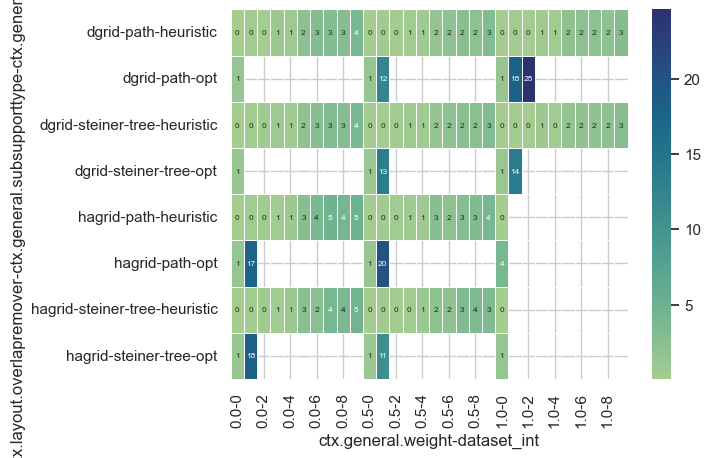

In [48]:
import matplotlib.pyplot as plt


sns.heatmap(
    good_runs.pivot_table(
        index=[
            "ctx.layout.overlapremover",
            "ctx.general.subsupporttype",
            "ctx.general.strategy",
        ],
        columns=[
            "ctx.general.weight",
            "dataset_int",
        ],
        values="duration_m",
        aggfunc='mean',
    ),
    linewidth=0.5,
    annot=True,
    annot_kws={"fontsize":6},
    fmt=".0f",
    cmap="crest",
)


## Projections

Let's plot the quality metrics for the projection. We are interested in how they relate to the weight parameter.

All metrics (trustworthiness, continuity, stress) show the same pattern. (Higher is better for the former two, lower is better for the latter.) For element similarity, the projection is best for weight 0, worse for 0.5 and worst at 1. For set similairty, it is the other way around. Considering an average of both metrics, weight 0.5 is the best.

In [49]:

good_runs.pivot_table(
    index=["ctx.general.weight"],
    columns=[  'ctx.layout.overlapremover'],
    values=["EA: stress", "SR: stress", "M1 [EA, k=10%]", "M1 [SR, k=10%]", "M2 [EA, k=10%]", "M2 [SR, k=10%]"],
    aggfunc='mean'
).round(3)



EA: stress        M1 [EA, k=10%]         \
ctx.layout.overlapremover      dgrid hagrid          dgrid hagrid   
ctx.general.weight                                                  
0.0                            0.031  0.066          0.907  0.832   
0.5                            0.124  0.131          0.662  0.638   
1.0                            0.187  0.200          0.540  0.506   

                          M1 [SR, k=10%]        M2 [EA, k=10%]         \
ctx.layout.overlapremover          dgrid hagrid          dgrid hagrid   
ctx.general.weight                                                      
0.0                                0.535  0.534          0.947  0.837   
0.5                                0.870  0.818          0.620  0.594   
1.0                                0.913  0.856          0.525  0.473   

                          M2 [SR, k=10%]        SR: stress         
ctx.layout.overlapremover          dgrid hagrid      dgrid hagrid  
ctx.general.weight                                                 
0.0                                0.528  0.529      0.325  0.321  
0.5                                0.884  0.811      0.151  0.194  
1.0                                0.916  0.861      0.123  0.129

## Network structure

Next, we consider the number of edges and their crossings in the drawing. We do not consider lines on edges. The image below shows these numbers for successful heuristic runs (as there few optimal runs for N > 20) using the `DGrid` gridifier (as Hagrid ILP and alpha=1 are a problem).

We can see the expected relations: 
- alpha=0, not reflecting set relations well, requires the most edges
- Consequently, edges decrease as alpha increases
- A path support needs more edges than a tree support
- A jump in edges from N=100 to N=120 as the grid size increases from 32x32 to 64x64 there

/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_6883/848106763.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(labels)
/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_6883/848106763.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(labels)
/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_6883/848106763.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels(["%.0f" % i for i in axes[0].get_yticks()], fontsize=16)
/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_6883/848106763.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels(["%.0f" % i for i in axes[1].get_yticks()], fontsize=16)
/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_6883/848106763.py:51: UserWarning: FixedFormatter should only be used together with

[Text(0, 0, '20'),
 Text(1, 0, '40'),
 Text(2, 0, '60'),
 Text(3, 0, '80'),
 Text(4, 0, '100'),
 Text(5, 0, '120'),
 Text(6, 0, '140'),
 Text(7, 0, '160'),
 Text(8, 0, '180'),
 Text(9, 0, '200')]

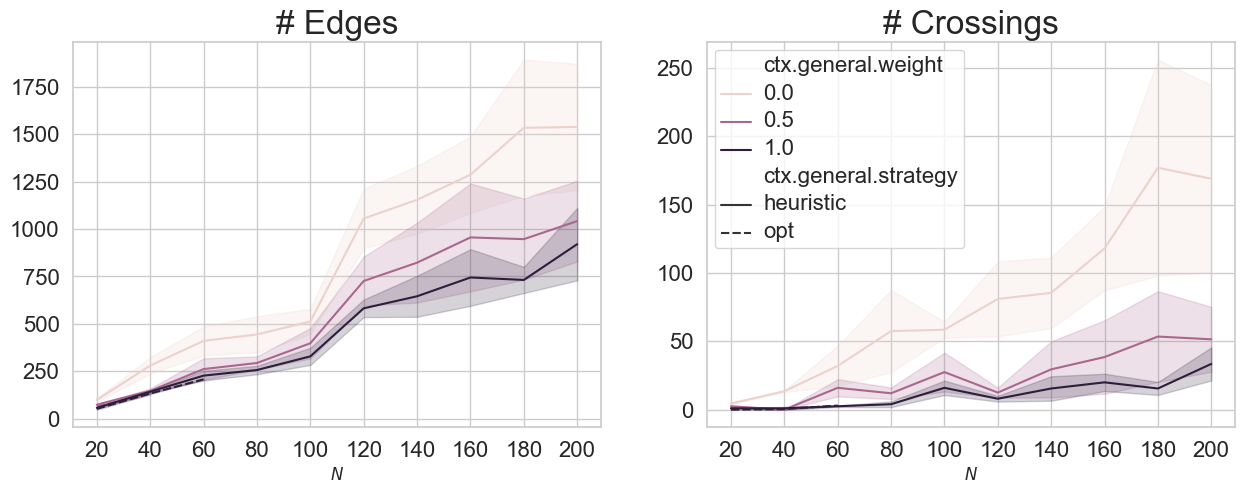

In [50]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15, 5))


axes[0].set_title("Total Edges")
axes[1].set_title("Total Edge Crossings")

subset = good_runs[(good_runs['ctx.layout.overlapremover']=='dgrid')].sort_values("dataset_int")

sns.lineplot(
    data=subset,
    x="dataset",
    y="metrics[0].total_edges",
    style="ctx.general.strategy",
    errorbar=('sd', 1),
    estimator='mean',
    sort=False,
    hue="ctx.general.weight",
    ax=axes[0],
    legend=None
)
sns.lineplot(
    data=subset,
    x="dataset",
    y="metrics[0].total_edge_crossings",
    style="ctx.general.strategy",
    errorbar=('sd', 1),
    estimator='mean',
    sort=False,
    hue="ctx.general.weight",
    ax=axes[1]
)

labels = range(20, 201, 20)

axes[0].set_title("# Edges", fontsize=24)
axes[1].set_title("# Crossings", fontsize=24)


plt.setp(axes[1].get_legend().get_texts(), fontsize="16")  # for legend text
plt.setp(axes[1].get_legend().get_title(), fontsize="16")  # for legend title

axes[0].set_xticklabels(labels)
axes[1].set_xticklabels(labels)
axes[0].set_xlabel("$N$")
axes[1].set_xlabel("$N$")
axes[0].set_ylabel("")
axes[1].set_ylabel("")

axes[0].set_yticklabels(["%.0f" % i for i in axes[0].get_yticks()], fontsize=16)
axes[1].set_yticklabels(["%.0f" % i for i in axes[1].get_yticks()], fontsize=16)
axes[0].set_xticklabels(["%.0f" % int((i+1)*20) for i in axes[0].get_xticks()], fontsize=16)
axes[1].set_xticklabels(["%.0f" % int((i+1)*20) for i in axes[1].get_xticks()], fontsize=16)

Finally, let's take a closer look at N <= 40, where we have comparable amounts of heuristic and optimal runs.

/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_6883/4209316760.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(labels, fontsize=16)
/var/folders/d9/8l4xsjcd5_59v2f35x1y8dgm0000gn/T/ipykernel_6883/4209316760.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(["%.00f" % i for i in g.get_yticks()], fontsize=16)


[Text(0, 0.0, '0'),
 Text(0, 2.0, '2'),
 Text(0, 4.0, '4'),
 Text(0, 6.0, '6'),
 Text(0, 8.0, '8'),
 Text(0, 10.0, '10'),
 Text(0, 12.0, '12')]

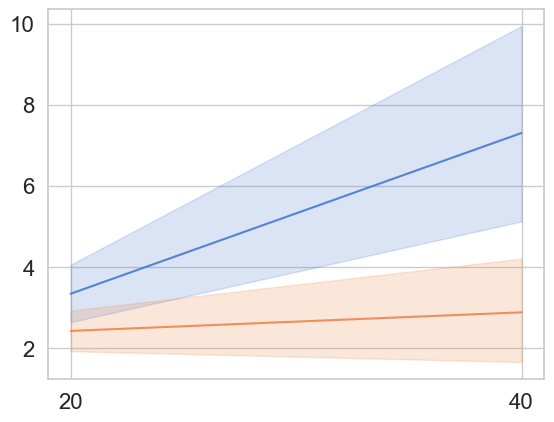

In [51]:
subset = good_runs[(good_runs["dataset_int"] < 2) ].sort_values('ctx.general.strategy')
sns.set_theme(style="whitegrid")
#g = sns.FacetGrid(data=subset)
#plt.ylim([-1,300])
g=sns.lineplot(
    data=subset,
    #style='ctx.general.strategy',
    x='dataset',
    y='metrics[0].total_edge_crossings',
    #y='metrics[0].total_edges',
    hue='ctx.general.strategy',
    #dodge=True,
    orient='x',
    #size=4,
    alpha=.9,
    #gap=.1,
    palette='muted',
    #hue='ctx.general.subsupporttype',
    legend=False
)

g.set_ylabel('')
g.set_xlabel('')
labels = [20,40]
g.set_xticklabels(labels, fontsize=16)
g.set_yticklabels(["%.00f" % i for i in g.get_yticks()], fontsize=16)

Hagrid ILP also generally leads to worse network quality metrics, presumably as a consequence of being worse in projecting data onto the grid.

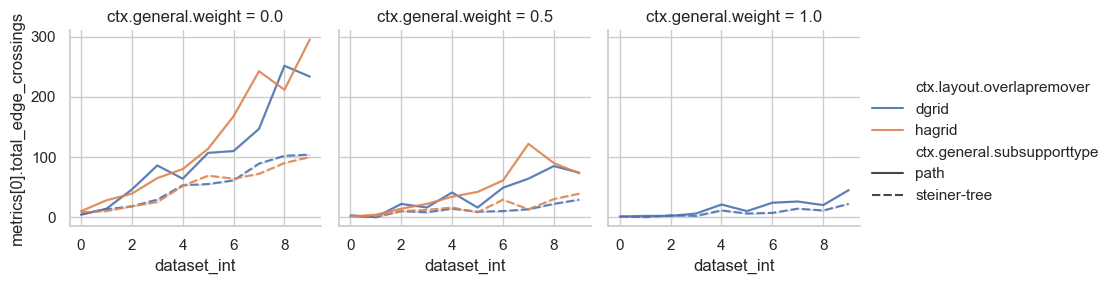

In [52]:
subset = good_runs[(good_runs["ctx.general.strategy"] =='heuristic') ].sort_values(['ctx.general.subsupporttype','ctx.layout.overlapremover'])
sns.set_theme(style="whitegrid")
g = sns.FacetGrid(data=subset,col='ctx.general.weight')
#plt.ylim([-1,300])
g.map_dataframe(sns.lineplot,
    #data=subset,
    x='dataset_int',
    y='metrics[0].total_edge_crossings',
    #y='metrics[0].total_edges',
    #dodge=True,
    orient='x',
    #size=4,
    alpha=.9,
    #gap=.1,
    #hue='ctx.general.subsupporttype',
    #palette='tab10',
    style='ctx.general.subsupporttype',
    hue='ctx.layout.overlapremover',
    estimator='mean',
    errorbar=('sd',1)
)
g.add_legend()
#g.set_ylabel('')
#g.set_xlabel('')
#labels = [20,40]
#g.set_xticklabels(labels, fontsize=16)
#g.set_yticklabels(["%.00f" % i for i in g.get_yticks()], fontsize=16)